# Packet Based Markovian Model for steady state throughput of CUBIC and Hybla

In this notebook, we investigate the adapted packet-based model for CUBIC and Hybla.

As before, we first print certain metrics to make sure the different steps in the computation are as wished.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ccaModels import CCA_MarkovChain_CUBIC_packet, CCA_MarkovChain_Hybla_packet

#plt.rcParams['text.usetex'] = True
#plt.rcParams.update(plt.rcParamsDefault)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


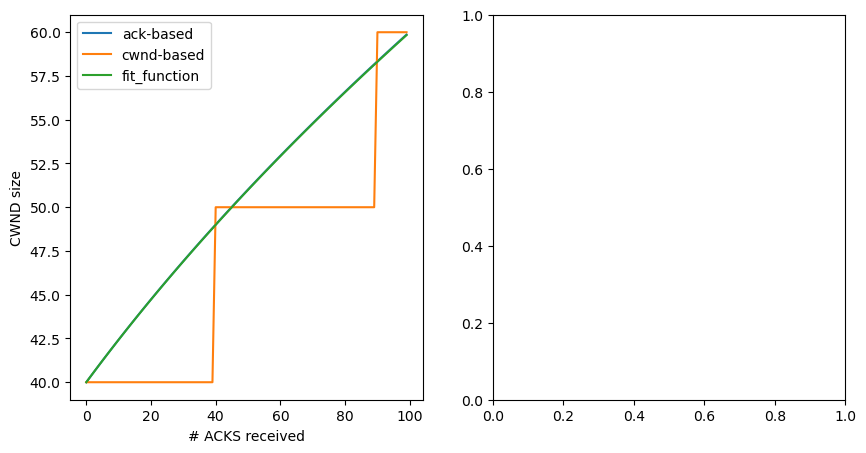

Integrating ack-based yields: 5058.815345921464
error with fit-function = 0.033760403271010375


In [2]:
# Example of the approximation for the difference equation nonlinear to linear non-difference equation.
# We can also add the continuous approximation to that.
T = 100
rho = 10
alpha = rho
start = 40
w = np.zeros(T)
wp = np.zeros(T)
wt = np.zeros(T)
fit_function = np.sqrt(2*alpha*np.arange(T)+start*start)
w[0] = start
wp[0] = start
wt[0] = 1
counter = 1
rtt_counter = 0
for t in range(1,T):
    w[t] = w[t-1] + alpha/w[t-1]
    wt[t] = wt[0] + alpha * rtt_counter
    if counter == wp[t-1]:
        wp[t] = wp[t-1] + alpha
        counter = 0
        rtt_counter += 1
    else:
        wp[t] = wp[t-1]
    counter+=1

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(w, label="ack-based")
axs[0].plot(wp, label="cwnd-based")
axs[0].plot(fit_function, label="fit_function")
axs[0].legend()
axs[0].set_ylabel("CWND size")
axs[0].set_xlabel("# ACKS received")
#axs[1].plot(wt, label="time-based")
#axs[1].legend()
plt.show()

print(f"Integrating ack-based yields: {np.sum(w)}")
#print(f"Integrating cwnd-based yields: {np.sum(wp)}")
print(f"error with fit-function = {w[-1]-fit_function[-1]}")

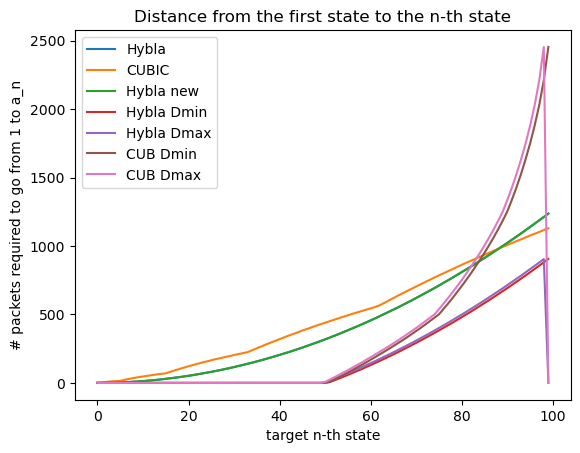

1.0
5.0


In [4]:
hyb = CCA_MarkovChain_Hybla_packet(packet_err=0.0006,beta=0.5,N=100, C=1000, RTT_real = 1, RTT0=0.05)
cub = CCA_MarkovChain_CUBIC_packet(packet_err = 0.0006, beta=0.5,N=100, C=1000, RTT_real = 1,alpha=4)
rho = 1/0.05
def newD(a,b):
    return (b*b-a*a)/(2*rho*rho)

a = 1
d = np.zeros(100)
dc = np.zeros(100)
for i,ai in enumerate(hyb.a):
    d[i] = hyb.D(1,ai)
for i,ai in enumerate(cub.a):
    dc[i] = cub.D(1,ai)
plt.title("Distance from the first state to the n-th state")
plt.ylabel("# packets required to go from 1 to a_n")
plt.xlabel("target n-th state")
plt.plot(d,label="Hybla") 
plt.plot(dc,label="CUBIC")
plt.plot(newD(np.ones(len(hyb.a)),hyb.a),label="Hybla new")
plt.plot(hyb.Dmin[50,:], label = "Hybla Dmin")
plt.plot(hyb.Dmax[50,:], label = "Hybla Dmax")
plt.plot(cub.Dmin[50,:], label = "CUB Dmin")
plt.plot(cub.Dmax[50,:], label = "CUB Dmax")
plt.legend()             
plt.show()
print(hyb.Dmin[50,50])
print(hyb.Dmax[50,50])

Rho is equal to 10.0
Average throughput is 2950.5444760064647


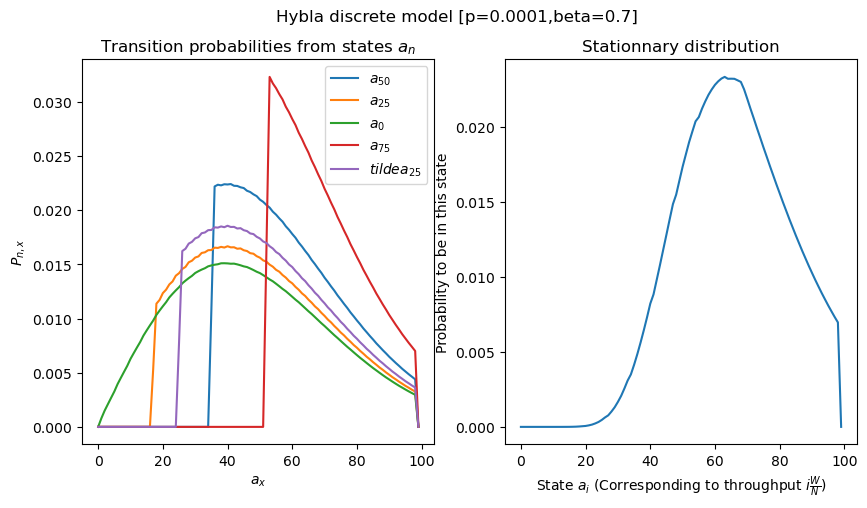

In [2]:
p = 0.0001
b = 0.7
wired = CCA_MarkovChain_Hybla_packet(packet_err=p,beta=b,N=100,C = 5000, RTT_real = 0.5, RTT0=0.05)
wired.avg_throughput()
print(f"Rho is equal to {wired.rho}")
print(f"Average throughput is {wired.ssThroughput}")

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(np.arange(wired.N),wired.P[50,:],label = "$a_{50}$")
axs[0].plot(np.arange(wired.N),wired.P[25,:],label = "$a_{25}$")
axs[0].plot(np.arange(wired.N),wired.P[0,:],label = "$a_{0}$")
axs[0].plot(np.arange(wired.N),wired.P[75,:],label = "$a_{75}$")
axs[0].plot(np.arange(wired.N),wired.Ptilde[25,:],label = "$tilde a_{25}$")
axs[0].set_title(r"Transition probabilities from states $a_n$")
axs[0].set_ylabel(r"$P_{n,x}$")
axs[0].set_xlabel(r"$a_x$")
axs[0].legend()
axs[1].plot(np.arange(wired.N),wired.pi)
axs[1].set_title(r"Stationnary distribution")
axs[1].set_xlabel(r"State $a_i$ (Corresponding to throughput $i\frac{W}{N}$)")
axs[1].set_ylabel(r'Probability to be in this state')
fig.suptitle(f"Hybla discrete model [p={p},beta={b}]")
plt.show()

0.001 682.7001433109233
0.028183829312644536 445.9891940088101
0.7943282347242815 174.74849558411407


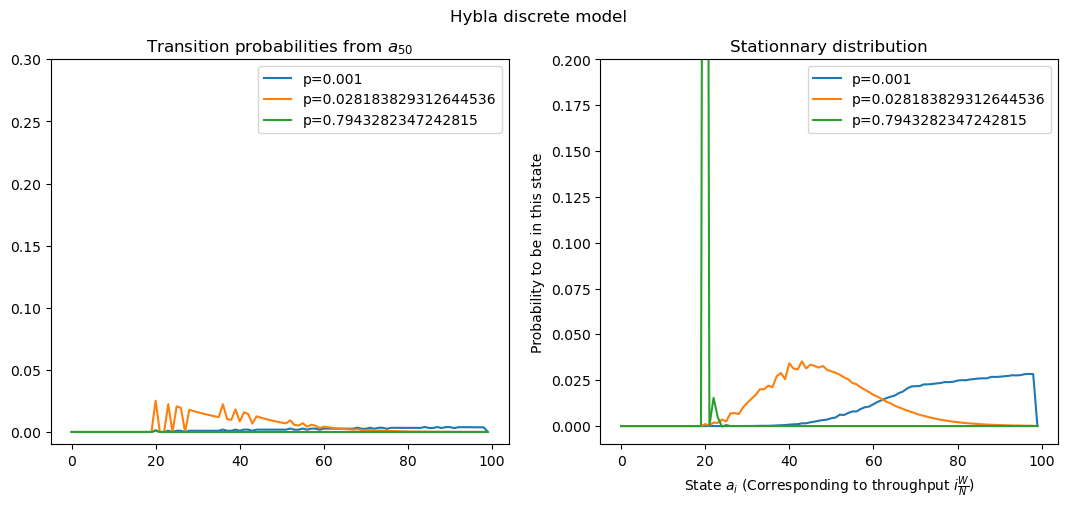

In [3]:
wired = CCA_MarkovChain_Hybla_packet(packet_err=0.001,beta=0.7,N=100,C = 1000, RTT_real = 0.25, RTT0=0.025)
ps = np.logspace(-3,-0.1,3)
fig, axs = plt.subplots(1, 2, figsize=(13,5))
for i in ps:
    wired.packet_err = i
    wired.compute_stationnary_distribution()
    axs[0].plot(np.arange(wired.N),wired.P[20,:],label=f"p={i}")
    axs[1].plot(np.arange(wired.N),wired.pi,label=f"p={i}")
    print(i, wired.avg_throughput())

axs[1].set_title(r"Stationnary distribution")
axs[0].set_title(r"Transition probabilities from $a_{50}$")
axs[1].set_ylim(-0.01,0.2)
axs[0].set_ylim(-0.01,0.3)
#axs[0].set_xlim(10,15)
axs[1].set_xlabel(r"State $a_i$ (Corresponding to throughput $i\frac{W}{N}$)")
axs[1].set_ylabel(r'Probability to be in this state')
axs[1].legend()
axs[0].legend()
fig.suptitle(f"Hybla discrete model")
plt.show()

0.01 62.94317904385201 2.5 0.11361512828387077 0.001893885851841957
0.0460609969159666 23.613408331242038 2.5 0.4321321647415406 0.14242914686801042
0.21216154368926846 4.9700478695908075 2.5 0.9428197418763671 0.04295025956753302
0.9772372209558107 4.625 2.5 1.0 0.0


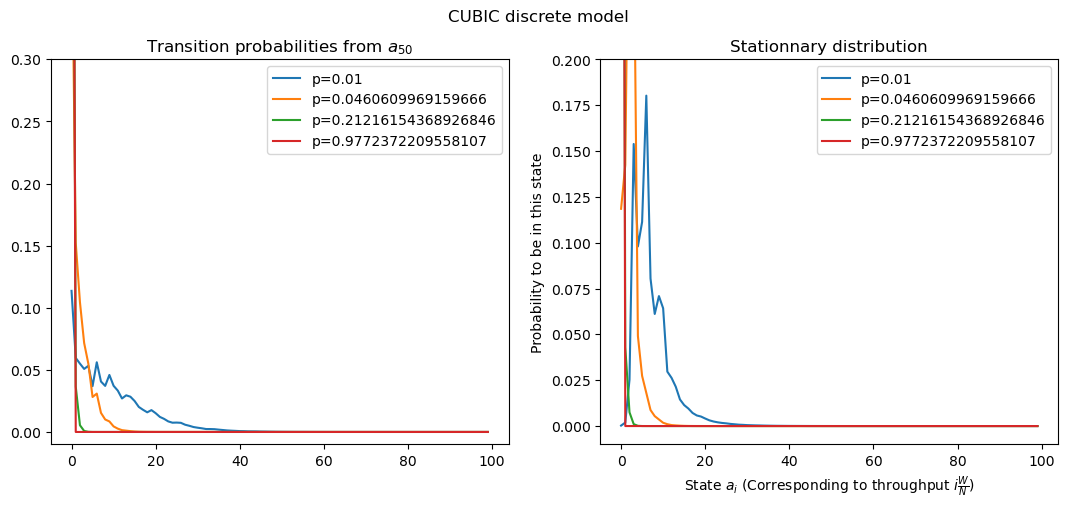

In [22]:
wired = CCA_MarkovChain_CUBIC_packet(packet_err=0.1,beta=0.7,N=100,C = 1000, RTT_real = 0.5)
ps = np.logspace(-2,-0.01,4)
fig, axs = plt.subplots(1, 2, figsize=(13,5))
for i in ps:
    wired.packet_err = i
    wired.compute_stationnary_distribution()
    axs[0].plot(np.arange(wired.N),wired.P[0,:],label=f"p={i}")
    axs[1].plot(np.arange(wired.N),wired.pi,label=f"p={i}")
    print(i, wired.avg_throughput(), wired.a[0], wired.P[0,0], wired.pi[1])

axs[1].set_title(r"Stationnary distribution")
axs[0].set_title(r"Transition probabilities from $a_{50}$")
axs[1].set_ylim(-0.01,0.2)
axs[0].set_ylim(-0.01,0.3)
#axs[0].set_xlim(10,15)
axs[1].set_xlabel(r"State $a_i$ (Corresponding to throughput $i\frac{W}{N}$)")
axs[1].set_ylabel(r'Probability to be in this state')
axs[1].legend()
axs[0].legend()
fig.suptitle(f"CUBIC discrete model")
plt.show()

2.5 to 5.0. U =0.1 Uf=0.0 D = 0 = 0
252.5 to 255.0. U =0.1 Uf=0.0 D = 25 = 25
377.5 to 380.0. U =0.1 Uf=0.0 D = 37 = 37
2.5 to 5.0. U =0.1 Uf=0.0 D = 0 = 0
252.5 to 255.0. U =0.1 Uf=0.0 D = 25 = 25
377.5 to 380.0. U =0.1 Uf=0.0 D = 37 = 37


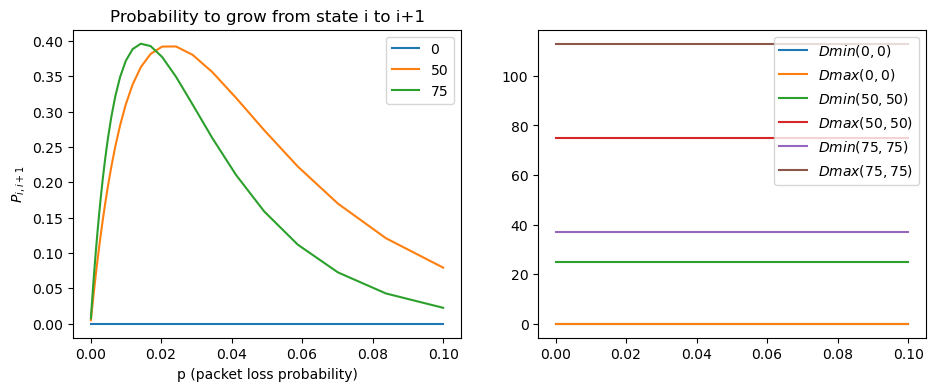

In [6]:
hyb = CCA_MarkovChain_Hybla_packet(packet_err=0.,beta=0.7,N=100,C =1000, RTT_real = 0.5, RTT0=0.1)
probij = np.zeros((40,3))
ps = np.logspace(-4,-1,40)
probe_states = [0,50,75]
d_mins = np.zeros((40,3))
d_maxs = np.zeros((40,3))
for i,p in enumerate(ps):
    hyb.packet_err = p
    hyb.compute_stationnary_distribution()
    for j,start in enumerate(probe_states):
        probij[i,j] = hyb.Ptilde[start,start+1]
        d_mins[i,j] = hyb.Dmin[start,start+1]
        d_maxs[i,j] = hyb.Dmax[start,start+1]
        if i%20==0:
            a = hyb.a[start]
            b = (start+1)*hyb.W/hyb.N
            U = (b-a)/hyb.rho**2
            Uf = np.floor(U)
            print(f"{a} to {b}. U ={U} Uf={Uf} D = {int(U*(a+Uf*hyb.rho**2)-hyb.rho**2*(Uf+Uf**2)/2)} = {hyb.D(hyb.a[start],(start+1)*hyb.W/hyb.N)}")
#also do a plot for the nmin and nmax starting from these 3 states,
fig, axs = plt.subplots(1, 2, figsize=(11,4))
for a,b in enumerate(probe_states):
    axs[1].plot(ps,d_mins[:,a],label = f"$Dmin({b},{b})$")
    axs[1].plot(ps,d_maxs[:,a],label = f"$Dmax({b},{b})$")
    axs[0].plot(ps,probij[:,a], label = f"{b}")
axs[0].set_title(f"Probability to grow from state i to i+1")
axs[0].set_xlabel("p (packet loss probability)")
axs[0].set_ylabel("$P_{i,i+1}$")
axs[0].legend()
axs[1].legend()

/Users/jeanmegret/OneDrive - Nexus365/Dissertation/qpepcca/ccaModels.py:322: RuntimeWarning: invalid value encountered in divide
  self.pi = np.real(vs/vs.sum())[:,0]


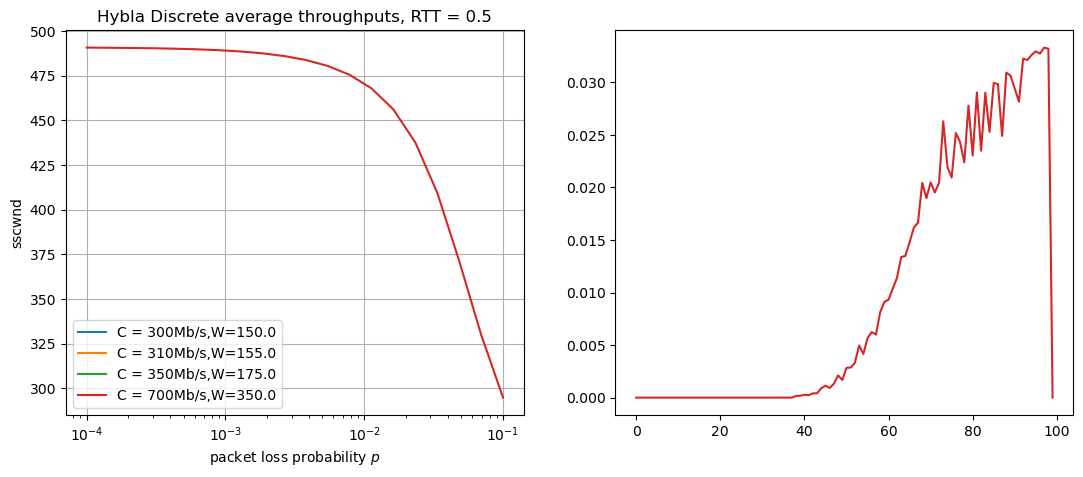

In [7]:
err_rates = np.logspace(-4,-1,20)
bandwidths = [300,310,350,700]
RTT = 0.5
throughputs = np.zeros([len(bandwidths),len(err_rates)])
sdistr = np.zeros([len(bandwidths),100])
for k,C in enumerate(bandwidths):
    sdistr[k,:] = CCA_MarkovChain_Hybla_packet(packet_err=1e-3,beta=0.7,N=100,C = C,RTT_real=RTT, RTT0=0.025).compute_stationnary_distribution()
    for i, l in enumerate(err_rates):
        wireless = CCA_MarkovChain_Hybla_packet(packet_err=l,beta=0.7,N=100,C = C,RTT_real=RTT, RTT0=0.025)
        throughputs[k,i] = wireless.avg_throughput()
fig, axs = plt.subplots(1, 2, figsize=(13,5))
for k,C in enumerate(bandwidths):
    axs[0].plot(err_rates,throughputs[k,:], label = f"C = {C}Mb/s,W={RTT*C}")
    axs[1].plot(np.arange(wireless.N),sdistr[k])
axs[0].semilogx()
axs[0].legend()
axs[0].grid()
axs[0].set_title(f"Hybla Discrete average throughputs, RTT = {RTT}")
axs[0].set_xlabel(r"packet loss probability $p$")
axs[0].set_ylabel(r'sscwnd')
plt.show()

Average throughput is 26.446064880973914


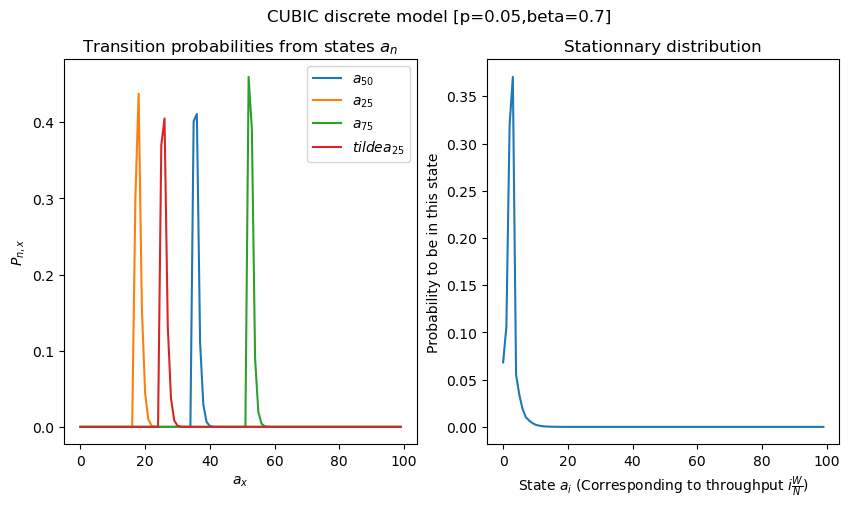

In [9]:
p = 0.05
b = 0.7
wired = CCA_MarkovChain_CUBIC_packet(packet_err=p,beta=b,N=100,C =1000, RTT_real = 0.21)
wired.avg_throughput()
print(f"Average throughput is {wired.ssThroughput}")

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(np.arange(wired.N),wired.P[50,:],label = "$a_{50}$")
axs[0].plot(np.arange(wired.N),wired.P[25,:],label = "$a_{25}$")
axs[0].plot(np.arange(wired.N),wired.P[75,:],label = "$a_{75}$")
axs[0].plot(np.arange(wired.N),wired.Ptilde[25,:],label = "$tilde a_{25}$")
axs[0].set_title(r"Transition probabilities from states $a_n$")
axs[0].set_ylabel(r"$P_{n,x}$")
axs[0].set_xlabel(r"$a_x$")
axs[0].legend()
axs[1].plot(np.arange(wired.N),wired.pi)
axs[1].set_title(r"Stationnary distribution")
axs[1].set_xlabel(r"State $a_i$ (Corresponding to throughput $i\frac{W}{N}$)")
axs[1].set_ylabel(r'Probability to be in this state')
fig.suptitle(f"CUBIC discrete model [p={p},beta={b}]")
plt.show()

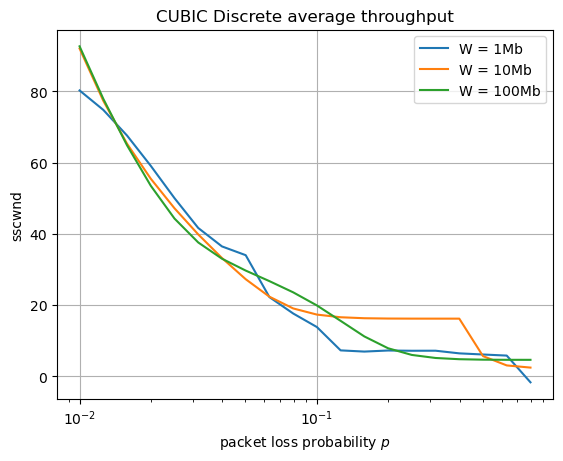

In [10]:
err_rates = np.logspace(-2,-0.1,20)
throughputs = np.zeros([3,len(err_rates)])
for k,C in enumerate([100,500,1000]):
    for i, l in enumerate(err_rates):
        wireless = CCA_MarkovChain_CUBIC_packet(packet_err=l,beta=0.7,N=100,C = C,RTT_real=0.1)
        throughputs[k,i] = wireless.avg_throughput()

plt.plot(err_rates,throughputs[0,:], label = "W = 1Mb")
plt.plot(err_rates,throughputs[1,:], label = "W = 10Mb")
plt.plot(err_rates,throughputs[2,:], label = "W = 100Mb")
plt.semilogx()
plt.legend()
plt.grid()
plt.title(r"CUBIC Discrete average throughput")
plt.xlabel(r"packet loss probability $p$")
plt.ylabel(r'sscwnd')
plt.show()

How do they depend on different RTTs?

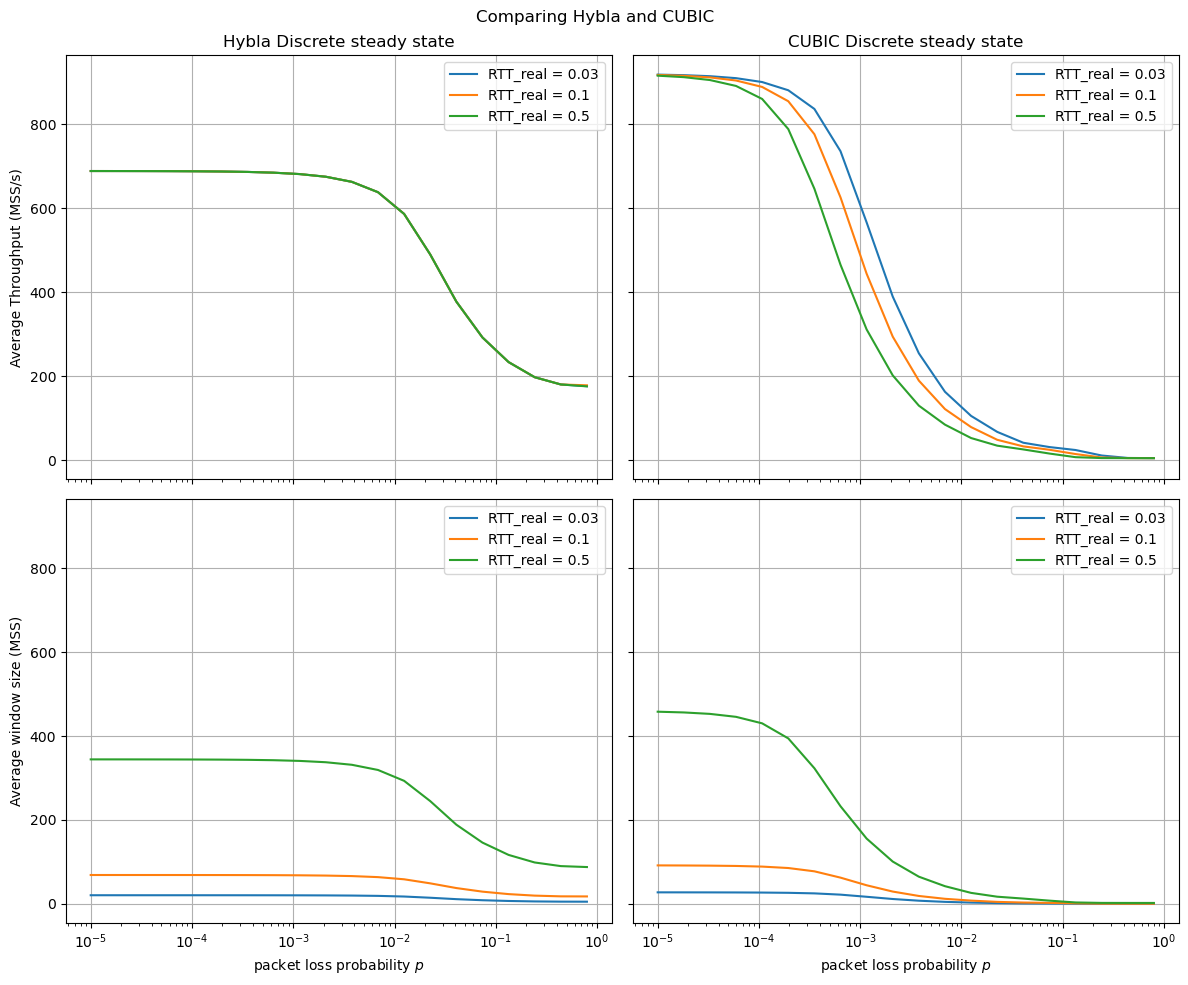

In [11]:
err_rates = np.logspace(-5,-0.1,20)
RTTs = [0.03, 0.1,0.5]
throughputs = np.zeros([len(RTTs),len(err_rates),4])

for k,R in enumerate(RTTs):
    for i, l in enumerate(err_rates):
        wireless = CCA_MarkovChain_Hybla_packet(packet_err=l,beta=0.7,N=100,C = 1000,RTT_real=R, RTT0=0.025)
        cubic = CCA_MarkovChain_CUBIC_packet(packet_err=l,beta=0.7,N=100,C = 1000,RTT_real=R)
        throughputs[k,i,0] = wireless.avg_throughput()
        throughputs[k,i,1] = cubic.avg_throughput()
    throughputs[k,:,2] = throughputs[k,:,0]*R
    throughputs[k,:,3] = throughputs[k,:,1]*R

fig, axs = plt.subplots(2, 2, figsize=(12,10),sharex=True, sharey=True)
for k,R in enumerate(RTTs):
    axs[0,0].plot(err_rates,throughputs[k,:,0], label = f"RTT_real = {R}")
    axs[0,1].plot(err_rates,throughputs[k,:,1], label = f"RTT_real = {R}")
    axs[1,0].plot(err_rates,throughputs[k,:,2], label = f"RTT_real = {R}")
    axs[1,1].plot(err_rates,throughputs[k,:,3], label = f"RTT_real = {R}")
axs[0,0].semilogx()
axs[0,0].legend()
axs[0,0].grid()
axs[0,0].set_title(r"Hybla Discrete steady state")
axs[0,0].set_ylabel(r'Average Throughput (MSS/s)')
axs[0,1].semilogx()
axs[0,1].legend()
axs[0,1].grid()
axs[0,1].set_title(r"CUBIC Discrete steady state")
axs[1,0].semilogx()
axs[1,0].legend()
axs[1,0].grid()
axs[1,0].set_xlabel(r"packet loss probability $p$")
axs[1,0].set_ylabel(r'Average window size (MSS)')
axs[1,1].semilogx()
axs[1,1].legend()
axs[1,1].grid()
axs[1,1].set_xlabel(r"packet loss probability $p$")
fig.suptitle("Comparing Hybla and CUBIC")
fig.tight_layout()
plt.show()

/Users/jeanmegret/OneDrive - Nexus365/Dissertation/qpepcca/ccaModels.py:322: RuntimeWarning: invalid value encountered in divide
  self.pi = np.real(vs/vs.sum())[:,0]


0.0
0.056423201124625184
112.56158062620115


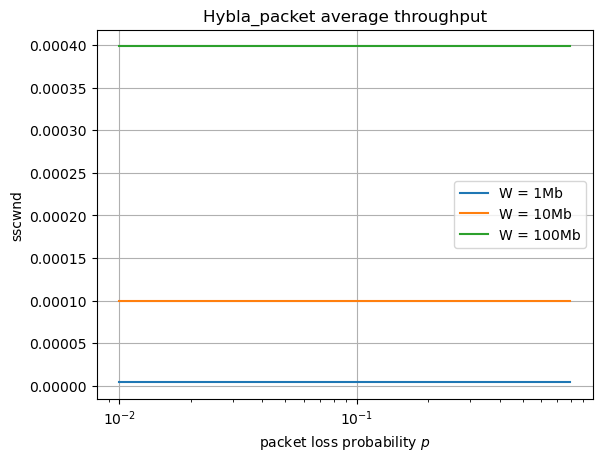

In [36]:
err_rates = np.logspace(-2,-0.1,20)
throughputs = np.zeros([3,len(err_rates)])
for k,C in enumerate([100,500,1000]):
    for i, l in enumerate(err_rates):
        wireless = CCA_MarkovChain_Hybla_packet(packet_err=l,beta=0.7,N=100,C = C,RTT_real=0.1)
        wireless.avg_throughput()
        throughputs[k,i] = wireless.S[0,0]
    print(np.sum(wireless.P[0,:]))

plt.plot(err_rates,throughputs[0,:], label = "W = 1Mb")
plt.plot(err_rates,throughputs[1,:], label = "W = 10Mb")
plt.plot(err_rates,throughputs[2,:], label = "W = 100Mb")
plt.semilogx()
plt.legend()
plt.grid()
plt.title(r"Hybla_packet average throughput")
plt.xlabel(r"packet loss probability $p$")
plt.ylabel(r'sscwnd')
plt.show()